<left>
    <h4>CNN + LSTM</h4>
</left>

---


=== Distribusi Kelas Setelah SMOTE ===
Class 0 (Diabetes): 2921
Class 1 (Non-diabetes): 2921
Class 2 (Prediabetes): 2921
Total data setelah SMOTE: 8763 sampel
Epoch 1/40


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4741 - loss: 1.0272 - val_accuracy: 0.6754 - val_loss: 0.7620
Epoch 2/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6865 - loss: 0.7033 - val_accuracy: 0.7165 - val_loss: 0.6412
Epoch 3/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7296 - loss: 0.6033 - val_accuracy: 0.7245 - val_loss: 0.6204
Epoch 4/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7389 - loss: 0.5834 - val_accuracy: 0.7370 - val_loss: 0.5797
Epoch 5/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7533 - loss: 0.5614 - val_accuracy: 0.7741 - val_loss: 0.5359
Epoch 6/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7738 - loss: 0.5252 - val_accuracy: 0.8015 - val_loss: 0.5118
Epoch 7/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7992 - loss: 0.4948 - val_accuracy: 0.7422 - val_loss: 0.5660
Epoch 8/40
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8101 - loss: 0.4721 - val_accuracy: 0.8346 - va

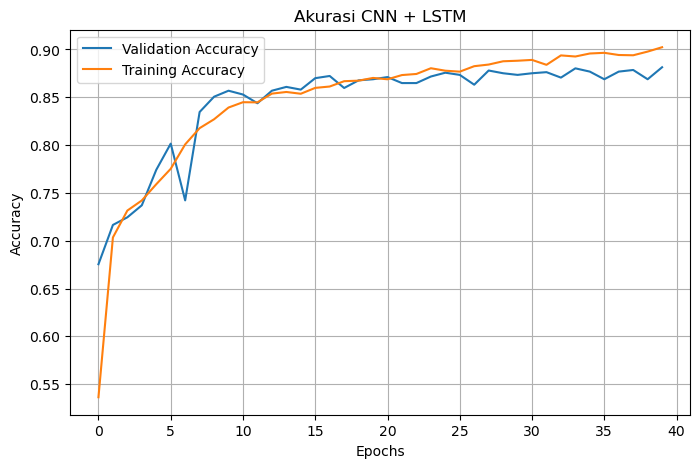

In [ ]:
# =============================================
# 🧩 CNN + LSTM (Baseline)
# =============================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- 1. Load data ---
df = pd.read_csv("../Dataset/data_scaled_clean.csv", delimiter=";")

# --- 2. Cleaning ---
df = df.replace(',', '.', regex=True)
df.columns = df.columns.str.strip().str.lower()

# --- 3. Fitur dan Label ---
X = df.drop(columns=['status', 'hba1c', 'berat', 'tinggi'])
y = df['status']

# --- 4. Encode Label ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 5. SMOTE Oversampling ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("\n=== Distribusi Kelas Setelah SMOTE ===")
unique, counts = np.unique(y_resampled, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u} ({le.inverse_transform([u])[0]}): {c}")
print(f"Total data setelah SMOTE: {len(y_resampled)} sampel")

# --- 6. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- 7. Normalisasi ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 8. Reshape (samples, timesteps, features=1) ---
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

# --- 9. Bangun model CNN + LSTM ---
model = Sequential([
    Conv1D(64, 2, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# --- 10. Compile ---
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- 11. Training ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=40, batch_size=32, verbose=1
)

# --- 12. Evaluasi ---
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\n🎯 Akurasi Test: {acc:.4f}, Loss: {loss:.4f}")

# --- 13. Plot Akurasi ---
plt.figure(figsize=(8,5))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title("Akurasi CNN + LSTM")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
# =============================================
# ⚙️ CNN + LSTM Hyperparameter Tuning (Keras Tuner)
# =============================================
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    # Jumlah filter CNN
    model.add(Conv1D(
        filters=hp.Choice('filters', [32, 64, 128]),
        kernel_size=hp.Choice('kernel_size', [2, 3]),
        activation='relu',
        input_shape=(X_train_scaled.shape[1], 1)
    ))
    model.add(MaxPooling1D(pool_size=2))
    # LSTM layer pertama
    model.add(LSTM(hp.Choice('lstm_units1', [32, 64, 128]), return_sequences=True))
    model.add(Dropout(hp.Choice('dropout1', [0.2, 0.3, 0.4])))
    # LSTM layer kedua
    model.add(LSTM(hp.Choice('lstm_units2', [16, 32, 64])))
    # Dense layer
    model.add(Dense(hp.Choice('dense_units', [32, 64, 128]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout2', [0.2, 0.3, 0.4])))
    # Output
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 1️⃣ Inisialisasi tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_lstm_tuning'
)

# --- 2️⃣ Jalankan pencarian ---
tuner.search(X_train_scaled, y_train, epochs=25, validation_data=(X_test_scaled, y_test), verbose=1)

# --- 3️⃣ Dapatkan model terbaik ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n=== Hyperparameter Terbaik ===")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# --- 4️⃣ Evaluasi akhir ---
loss, acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\n🎯 Akurasi Model Terbaik: {acc:.4f}, Loss: {loss:.4f}")


Trial 10 Complete [00h 01m 08s]
val_accuracy: 0.7895036935806274

Best val_accuracy So Far: 0.8910439014434814
Total elapsed time: 00h 10m 36s


c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



=== Hyperparameter Terbaik ===
filters: 32
kernel_size: 2
lstm_units1: 64
dropout1: 0.3
lstm_units2: 64
dense_units: 128
dropout2: 0.4
lr: 0.01

🎯 Akurasi Model Terbaik: 0.8910, Loss: 0.3486


Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.9002217054367065

Best val_accuracy So Far: 0.911308228969574
Total elapsed time: 00h 02m 23s
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Accuracy: 0.9113475177304965
              precision    recall  f1-score   support

    Diabetes       0.96      0.97      0.96       296
Non-diabetes       0.84      0.89      0.87       138
 Prediabetes       0.88      0.80      0.84       130

    accuracy                           0.91       564
   macro avg       0.89      0.89      0.89       564
weighted avg       0.91      0.91      0.91       564



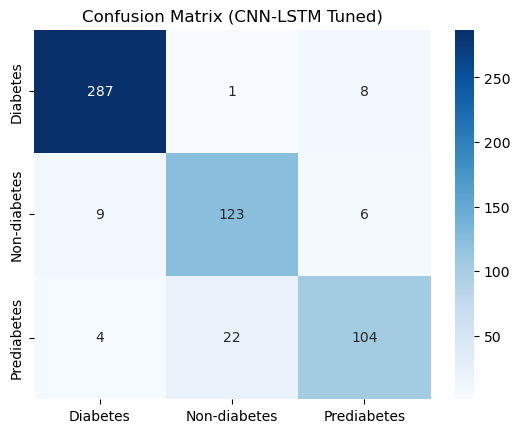

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================
# 1. LOAD & ROBUST CLEANING (FIXED)
# =============================================================
df = pd.read_csv("../Dataset/data_scaled_clean.csv", sep=';')
df = df.replace(',', '.', regex=True)
df.columns = df.columns.str.strip().str.lower()

# Fitur utama yang akan dipakai (Wajib dipilih di awal agar dropna tidak agresif)
features_raw = ['bmi', 'age', 'fgb', 'avg_systolyc', 'avg_dystolyc', 'insulin', 'status']
df = df[features_raw]  # Filter hanya kolom penting

# Convert ke numeric, error jadi NaN
numeric_cols = ['bmi', 'age', 'fgb', 'avg_systolyc', 'avg_dystolyc', 'insulin']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop NaN hanya jika ada error di kolom penting ini
df = df.dropna().reset_index(drop=True)

# Feature Engineering
df["insulin_log"] = np.log1p(df["insulin"])

# Final Features
final_features = ['bmi', 'age', 'fgb', 'avg_systolyc', 'avg_dystolyc', 'insulin_log']
X = df[final_features].values
y = df["status"]

print(f"Jumlah data valid: {len(df)}")  # Pastikan tidak 0

# Encode Label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# =============================================================
# 2. PREPROCESSING & RESHAPE
# =============================================================
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape ke 3D [Samples, Timesteps, Features] untuk CNN/LSTM
# Kita anggap 1 baris sebagai 1 timestep dengan N fitur
X_train_dl = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_dl = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Hitung Class Weight untuk imbalanced data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# =============================================================
# 3. DEFINE MODEL (HYPERTUNING)
# =============================================================
def build_model(hp):
    model = Sequential()
    
    # CNN Layer
    model.add(Conv1D(
        filters=hp.Int('filters', 32, 128, step=32),
        kernel_size=1,
        activation='relu',
        input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])
    ))
    
    # LSTM Layer
    model.add(LSTM(
        units=hp.Int('lstm_units', 32, 128, step=32),
        return_sequences=False
    ))
    
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# =============================================================
# 4. TUNING PROCESS
# =============================================================
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='tuning_dir',
    project_name='cnn_lstm_diabetes'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Mulai Hypertuning...")
tuner.search(X_train_dl, y_train, epochs=15, validation_split=0.2, callbacks=[stop_early], class_weight=class_weight_dict)

best_model = tuner.get_best_models(num_models=1)[0]

# =============================================================
# 5. EVALUATION
# =============================================================
y_pred_prob = best_model.predict(X_test_dl)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (CNN-LSTM Tuned)")
plt.show()


<left>
    <h1>CNN+LSTM Hypertuning + CV + SMOTE</h1>
</left>

---



Trial 30 Complete [00h 00m 09s]
val_accuracy: 0.814084529876709

Best val_accuracy So Far: 0.8295774459838867
Total elapsed time: 00h 04m 20s
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

Accuracy: 0.9131205673758865
              precision    recall  f1-score   support

    Diabetes       0.97      0.98      0.98       296
Non-diabetes       0.84      0.86      0.85       138
 Prediabetes       0.85      0.82      0.83       130

    accuracy                           0.91       564
   macro avg       0.89      0.89      0.89       564
weighted avg       0.91      0.91      0.91       564



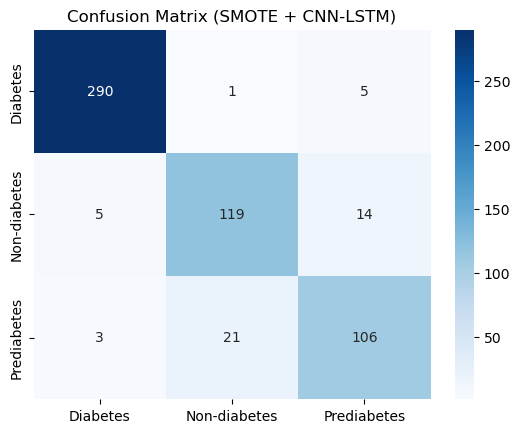

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE  # <--- IMPORT SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================================
# 1. LOAD & CLEAN DATA (Robust Cleaning)
# =============================================================
df = pd.read_csv("../Dataset/data_scaled_clean.csv", sep=';')
df = df.replace(',', '.', regex=True)
df.columns = df.columns.str.strip().str.lower()

# Pilih fitur penting saja agar dropna tidak menghabiskan data
features_raw = ['bmi', 'age', 'fgb', 'avg_systolyc', 'avg_dystolyc', 'insulin', 'status']
df = df[features_raw]

# Convert numeric
for col in ['bmi', 'age', 'fgb', 'avg_systolyc', 'avg_dystolyc', 'insulin']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna().reset_index(drop=True)

# Feature Engineering
df["insulin_log"] = np.log1p(df["insulin"])

final_features = ['bmi', 'age', 'fgb', 'avg_systolyc', 'avg_dystolyc', 'insulin_log']
X = df[final_features].values
y = df["status"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# =============================================================
# 2. SPLIT, SCALE, & SMOTE
# =============================================================
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- APPLY SMOTE (Hanya pada Data Training) ---
print(f"Data Train sebelum SMOTE: {np.bincount(y_train)}")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print(f"Data Train SETELAH SMOTE: {np.bincount(y_train_res)}")

# --- RESHAPE KE 3D UNTUK CNN-LSTM ---
# (Samples, Timesteps=1, Features)
X_train_dl = X_train_res.reshape((X_train_res.shape[0], 1, X_train_res.shape[1]))
X_test_dl = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# =============================================================
# 3. DEFINE MODEL (HYPERTUNING)
# =============================================================
def build_model(hp):
    model = Sequential()
    
    model.add(Conv1D(
        filters=hp.Int('filters', 32, 128, step=32),
        kernel_size=1,
        activation='relu',
        input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])
    ))
    
    model.add(LSTM(
        units=hp.Int('lstm_units', 32, 128, step=32),
        return_sequences=False
    ))
    
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# =============================================================
# 4. TUNING PROCESS
# =============================================================
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='tuning_smote_dir',
    project_name='cnn_lstm_smote'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("\nMulai Hypertuning dengan data SMOTE...")
# Note: class_weight DIHAPUS karena data sudah balanced via SMOTE
tuner.search(X_train_dl, y_train_res, epochs=15, validation_split=0.2, callbacks=[stop_early])

best_model = tuner.get_best_models(num_models=1)[0]

# =============================================================
# 5. EVALUATION
# =============================================================
y_pred_prob = best_model.predict(X_test_dl)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (SMOTE + CNN-LSTM)")
plt.show()